<br>

As far as I am concerned, there is a problem with the data. The problem stems from the different image planes.
There are three planes in MR images called sagittal, axial, and coronal [1].
However, the dataset contains images from all three planes, and this situation can reduce the model's robustness.
Although there is a problem, I yielded plausible accuracy and  an auc score using a basic architecture. 
<br>

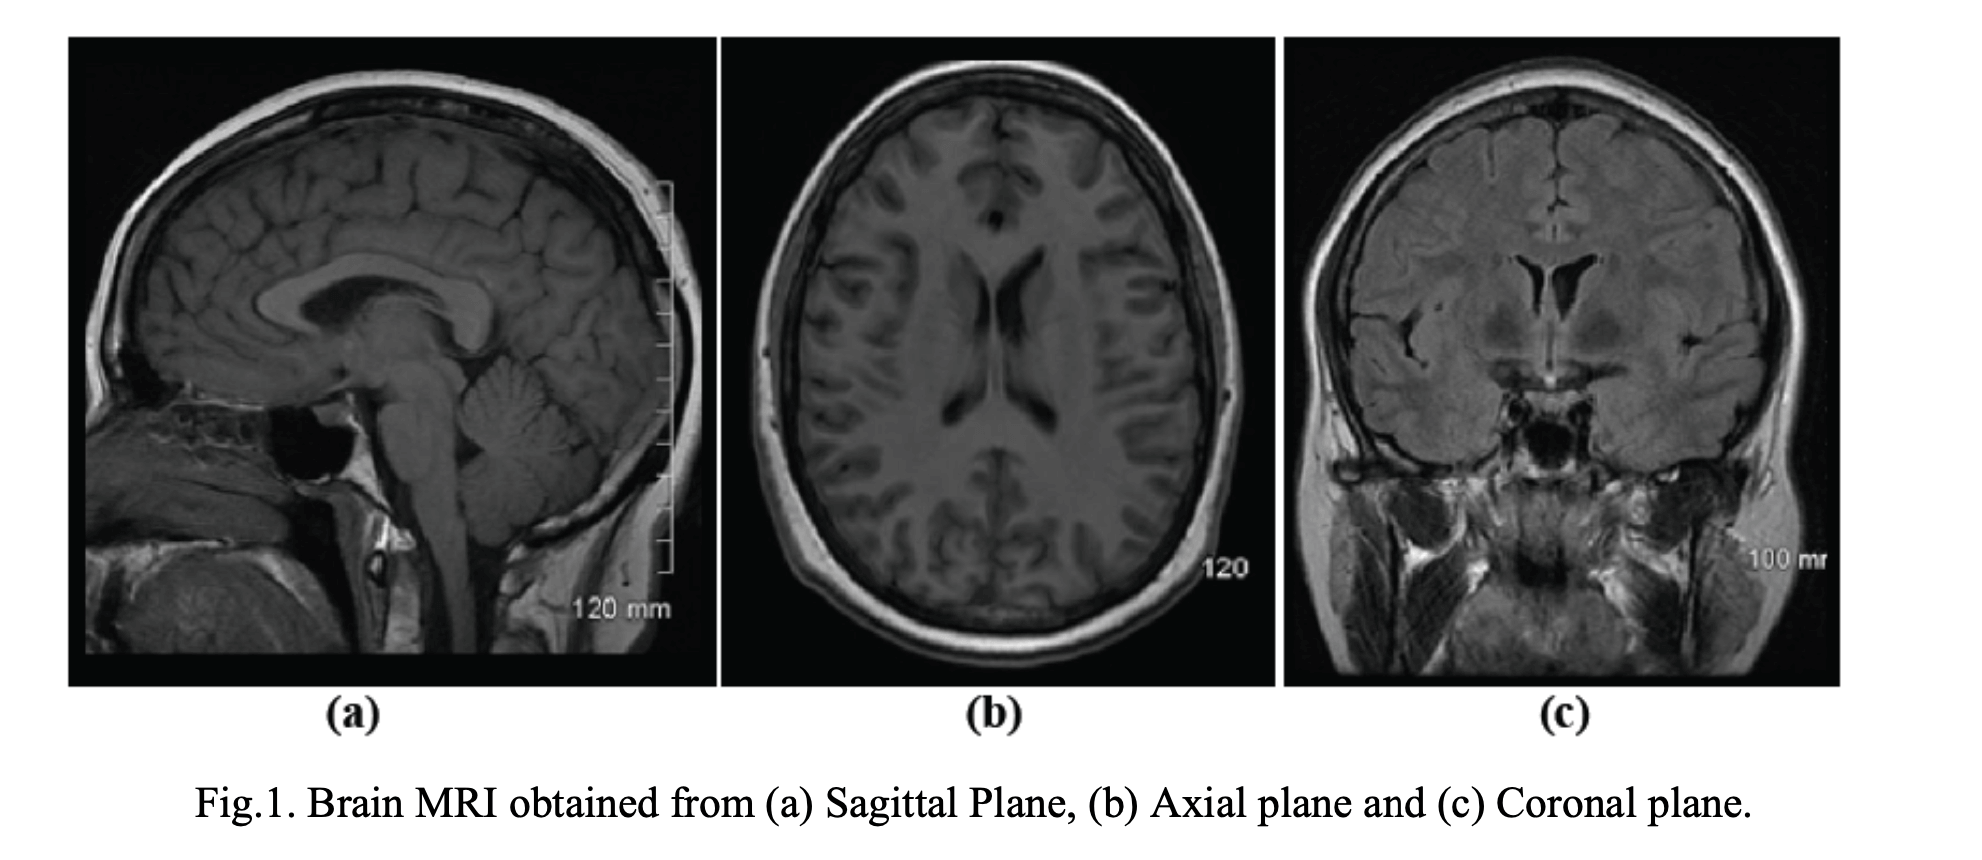
<br>

## Result
<p>Of course, this type of big fluctuation in validation metrics is not good. Changing some callbacks criteria help improve the model generalization. In my experience, sometimes the accuracy balances when epochs increase. </p>
<p>Test accuracy : 84.360 %</p>

## References
1. https://www.researchgate.net/publication/304891093_A_Study_of_MRI_Segmentation_Methods_in_Automatic_Brain_Tumor_Detection 

In [1]:
# Importing dependencies

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
from PIL import Image
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow.keras.layers import Dense, Dropout, Input,Conv2D,Flatten, Conv1D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# <span style="color:#e74c3c;"> Creating </span> Images DataFrame


In [2]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    data = []
    images = os.listdir(path)
    for i in tqdm(images, desc='images'):
        data.append(os.path.join(path, i))
        
    return data
    
data_normal = create_images_list('/kaggle/input/brain-tumors-dataset/Data/Normal')
data_glioma = create_images_list('/kaggle/input/brain-tumors-dataset/Data/Tumor/glioma_tumor')
data_meningioma = create_images_list('/kaggle/input/brain-tumors-dataset/Data/Tumor/meningioma_tumor')
data_pituitary = create_images_list('/kaggle/input/brain-tumors-dataset/Data/Tumor/pituitary_tumor')


# look-up table
tumor_classes = {0:'normal',
                1 : 'glioma',
                2 : 'meningioma',
                3 : 'pituitary'}


train_df = pd.concat([pd.DataFrame({"img": np.array(data_normal), "class": 0}),
                      pd.DataFrame({"img": np.array(data_glioma), "class":1}),
                      pd.DataFrame({"img": np.array(data_meningioma), "class":2}),
                      pd.DataFrame({"img": np.array(data_pituitary), "class":3}),
                     ], ignore_index = True)


train_df = shuffle(train_df).reset_index().drop(columns=['index'])
train_df.head()

images:   0%|          | 0/3066 [00:00<?, ?it/s]

images:   0%|          | 0/6307 [00:00<?, ?it/s]

images:   0%|          | 0/6391 [00:00<?, ?it/s]

images:   0%|          | 0/5908 [00:00<?, ?it/s]

,img,class
0,/kaggle/input/brain-tumors-dataset/Data/Normal...,0
1,/kaggle/input/brain-tumors-dataset/Data/Tumor/...,1
2,/kaggle/input/brain-tumors-dataset/Data/Tumor/...,2
3,/kaggle/input/brain-tumors-dataset/Data/Tumor/...,3
4,/kaggle/input/brain-tumors-dataset/Data/Tumor/...,3


# <span style="color:#e74c3c;"> Splitting </span> Dataset


In [3]:
#Splitting dataset into train(80%) and test(20%). Then, I splitted first 2000 instances of train dataset for validation.

X_train_, X_test, y_train_, y_test = train_test_split(train_df['img'], train_df['class'], test_size = 0.2, shuffle= True)

X_train = X_train_[3500:]
X_val = X_train_[:3500]


y_train_ = tf.keras.utils.to_categorical(y_train_)

y_train = y_train_[3500:]
y_val = y_train_[:3500]
y_test = tf.keras.utils.to_categorical(y_test)


print("X_train shape -> ", X_train.shape)
print("X_val shape -> ", X_val.shape)
print("X_test shape -> ", X_test.shape)


X_train shape ->  (13837,)
X_val shape ->  (3500,)
X_test shape ->  (4335,)


# <span style="color:#e74c3c;"> Creating </span> TensorFlow Dataset

In [4]:
# Creating preprocessing function for dataset loader.
# read -> convert -> resize -> scaling

def img_preprocessing(image, label):

    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.rgb_to_grayscale(img)
    img = tf.image.resize(img, size = (150,150))
    img = img/255.0
    
    return img, label

In [5]:
# Creating dataset loaders

train_loader = tf.data.Dataset.from_tensor_slices(( X_train, y_train) )
train_dataset = (train_loader.map(img_preprocessing).batch(32).shuffle(X_train.shape[0]).prefetch(32) )

validation_loader = tf.data.Dataset.from_tensor_slices(( X_val, y_val) )
validation_dataset = (train_loader.map(img_preprocessing).batch(32).shuffle(X_val.shape[0]).prefetch(32) )

test_loader = tf.data.Dataset.from_tensor_slices(( X_test, y_test) )
test_dataset = (test_loader.map(img_preprocessing).batch(32).shuffle(X_test.shape[0]).prefetch(32) )

# <span style="color:#e74c3c;"> CNN </span> Model

In [6]:
In = Input(shape=(150,150,1))

conv1 = Conv2D(32, (3,3), padding = 'same' , activation = 'relu')(In)
conv1 = BatchNormalization()(conv1)
conv1 = Dropout(0.1)(conv1)

conv2 = Conv2D(128, (3,3) , padding = 'same', activation = 'relu')(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = Dropout(0.1)(conv2)

pool = GlobalAveragePooling2D()(conv2)

dense1 = Dense(64, activation = 'relu')(pool)
Out = Dense(4, activation = 'softmax')(dense1)

model = Model(inputs = In, outputs = Out)

model.compile(optimizer = 'adam', loss ='categorical_crossentropy', metrics = [ 'accuracy',tf.keras.metrics.AUC(multi_label = True)] )
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 150, 150, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 128)     36992     
                                                                 
 batch_normalization_1 (Batc  (None, 150, 150, 128)    512       
 hNormalization)                                             

In [7]:
hist = model.fit(train_dataset, epochs = 100 , batch_size = 32,  
          verbose =1, validation_data = validation_dataset,
          callbacks = [ModelCheckpoint('best_weights.h5', save_best_only = True, monitor = 'val_accuracy'),
                      EarlyStopping(patience = 15, monitor = 'val_auc' )])

Epoch 1/100
433/433 [==============================] - 241s 369ms/step - loss: 1.0901 - accuracy: 0.5327 - auc: 0.7716 - val_loss: 4.1335 - val_accuracy: 0.2712 - val_auc: 0.6216
Epoch 2/100
433/433 [==============================] - 174s 363ms/step - loss: 0.9665 - accuracy: 0.5938 - auc: 0.8229 - val_loss: 1.0602 - val_accuracy: 0.5492 - val_auc: 0.8009
Epoch 3/100
433/433 [==============================] - 178s 372ms/step - loss: 0.8941 - accuracy: 0.6286 - auc: 0.8503 - val_loss: 1.3311 - val_accuracy: 0.4737 - val_auc: 0.8300
Epoch 4/100
433/433 [==============================] - 178s 376ms/step - loss: 0.8439 - accuracy: 0.6512 - auc: 0.8672 - val_loss: 0.8122 - val_accuracy: 0.6750 - val_auc: 0.8785
Epoch 5/100
433/433 [==============================] - 178s 373ms/step - loss: 0.7975 - accuracy: 0.6753 - auc: 0.8814 - val_loss: 0.8815 - val_accuracy: 0.6082 - val_auc: 0.8754
Epoch 6/100
433/433 [==============================] - 175s 368ms/step - loss: 0.7504 - accuracy: 0.6991 

In [8]:
eval_test = model.evaluate(test_dataset)
print('test accuracy : {0:.3f} %'.format(eval_test[1]*100))

136/136 [==============================] - 40s 141ms/step - loss: 0.4143 - accuracy: 0.8627 - auc: 0.9746
test accuracy : 86.275 %
